In [5]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [28]:
# формируем 2 выборки: 'старые' и 'новые' пользователи
df_old_user = df[df['user_type'] == 'registered_user']
df_new_user = df[df['user_type'] == 'new_user']

In [73]:
pd.crosstab(df_old_user['group'], df_old_user['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,72483,969
treatment,959,72829


In [74]:
pd.crosstab(df_new_user['group'], df_new_user['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,72791,959
treatment,1006,72482


In [75]:
# обе группы уникальны
sessions = df_new_user['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в выборке c 'новыми' пользователями.")

У нас имеются 0 пользователей, которые не уникальны в выборке c 'новыми' пользователями.


In [76]:
sessions = df_old_user['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в выборке со 'старыми' пользователями.")

У нас имеются 0 пользователей, которые не уникальны в выборке со 'старыми' пользователями.


In [77]:
# Анализ Мощности Выборки аналогичен 1 заданию
required_n = 4720  
control_sample_old_user = df_old_user[df_old_user['group'] == 'control'].sample(n = required_n, random_state=20)
treatment_sample_old_user = df_old_user[df_old_user['group'] == 'treatment'].sample(n = required_n, random_state=20)

# Сформируем общую случайную выборку
ab_df_old_user = pd.concat([control_sample_old_user, treatment_sample_old_user], axis=0)
ab_df_old_user.reset_index(drop=True, inplace=True)

In [78]:
ab_df_old_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [79]:
# то же самое делаем для группы с 'новыми' пользователями
#required_n = 4720  
control_sample_new_user = df_new_user[df_new_user['group'] == 'control'].sample(n = required_n, random_state=20)
treatment_sample_new_user = df_new_user[df_new_user['group'] == 'treatment'].sample(n = required_n, random_state=20)

# Сформируем общую случайную выборку
ab_df_new_user = pd.concat([control_sample_new_user, treatment_sample_new_user], axis=0)
ab_df_new_user.reset_index(drop=True, inplace=True)

In [80]:
ab_df_new_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [81]:
ab_df_old_user.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

In [82]:
ab_df_new_user.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

In [83]:
# рассчитываем выборочные статистики для обеих групп

conversion_rates = ab_df_old_user.groupby('group')['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.122881,0.328301,0.004779
treatment,0.119068,0.323868,0.004714


In [84]:
conversion_rates = ab_df_new_user.groupby('group')['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.105720,0.307479,0.004476
treatment,0.116314,0.320601,0.004667


In [85]:
#два эксперимента по выборочным статистикам показывают близкие друг к другу значения кроме за исключением 
# выборочного среднего коэффициента конверсии: в 'старой группе' ~12.3% против ~11.9%; в 'новой' - ~10.6% против ~11.6%

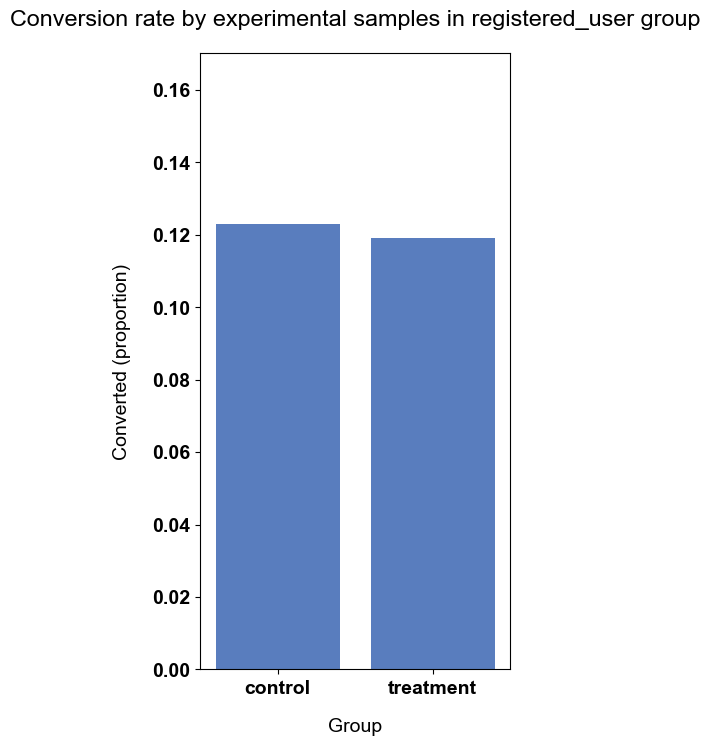

In [86]:
plt.figure(figsize=(4,8));
sns.barplot(x=ab_df_old_user['group'], y=ab_df_old_user['converted'], errorbar=('ci', False));
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples in registered_user group', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

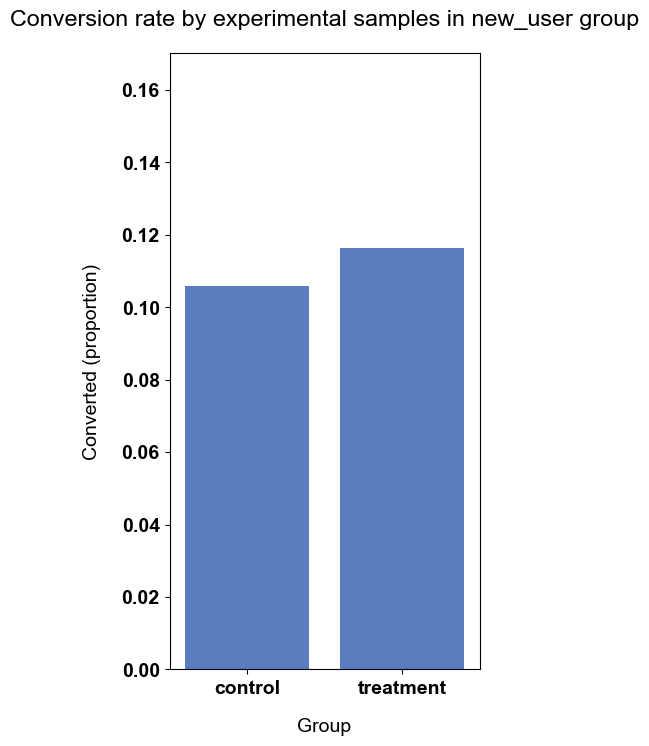

In [87]:
plt.figure(figsize=(4,8));
sns.barplot(x=ab_df_new_user['group'], y=ab_df_new_user['converted'], errorbar=('ci', False));
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples in new_user group', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [88]:
# рассчитываем p статистику для обеих групп
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_df_old_user[ab_df_old_user['group'] == 'control']['converted']
treatment_results = ab_df_old_user[ab_df_old_user['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 0.57
p-value: 0.570
CI 95% for control group: [0.114, 0.132]
CI 95% for treatment group: [0.110, 0.128]


In [89]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_df_new_user[ab_df_new_user['group'] == 'control']['converted']
treatment_results = ab_df_new_user[ab_df_new_user['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -1.64
p-value: 0.101
CI 95% for control group: [0.097, 0.114]
CI 95% for treatment group: [0.107, 0.125]


In [ ]:
# p-значение = 0.570 в группе 'старых' пользователей не позводяет отклонить нулевую гипотезу
# p-значение = 0.101 в группе 'новых' пользователей также не позводяет отклонить нулевую гипотезу
# таким образом, для 'старых' пользователей следует оставить 'старый' вариант работы, так как  при нем уровень конверсии даже выше, чем при 'новом' 
# для 'новых' пользователей следует оставить также 'старый' вариант работы, однако при 'новом' варианте работы уровень конверсии повышается, возможно, 
# доработав внесенные изменения удастся 'выйти' на статистически значимый уровень увеличения конверсии

In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
converted,294478.0,0.119659,0.324563,0.0,0.0,0.0,0.0,1.0


In [50]:
df.variants.value_counts(normalize=True)

variants
standard               0.5
svm_ensemble_v_1_22    0.5
Name: proportion, dtype: float64

In [51]:
df.location.value_counts()

location
United Kingdom    294478
Name: count, dtype: int64

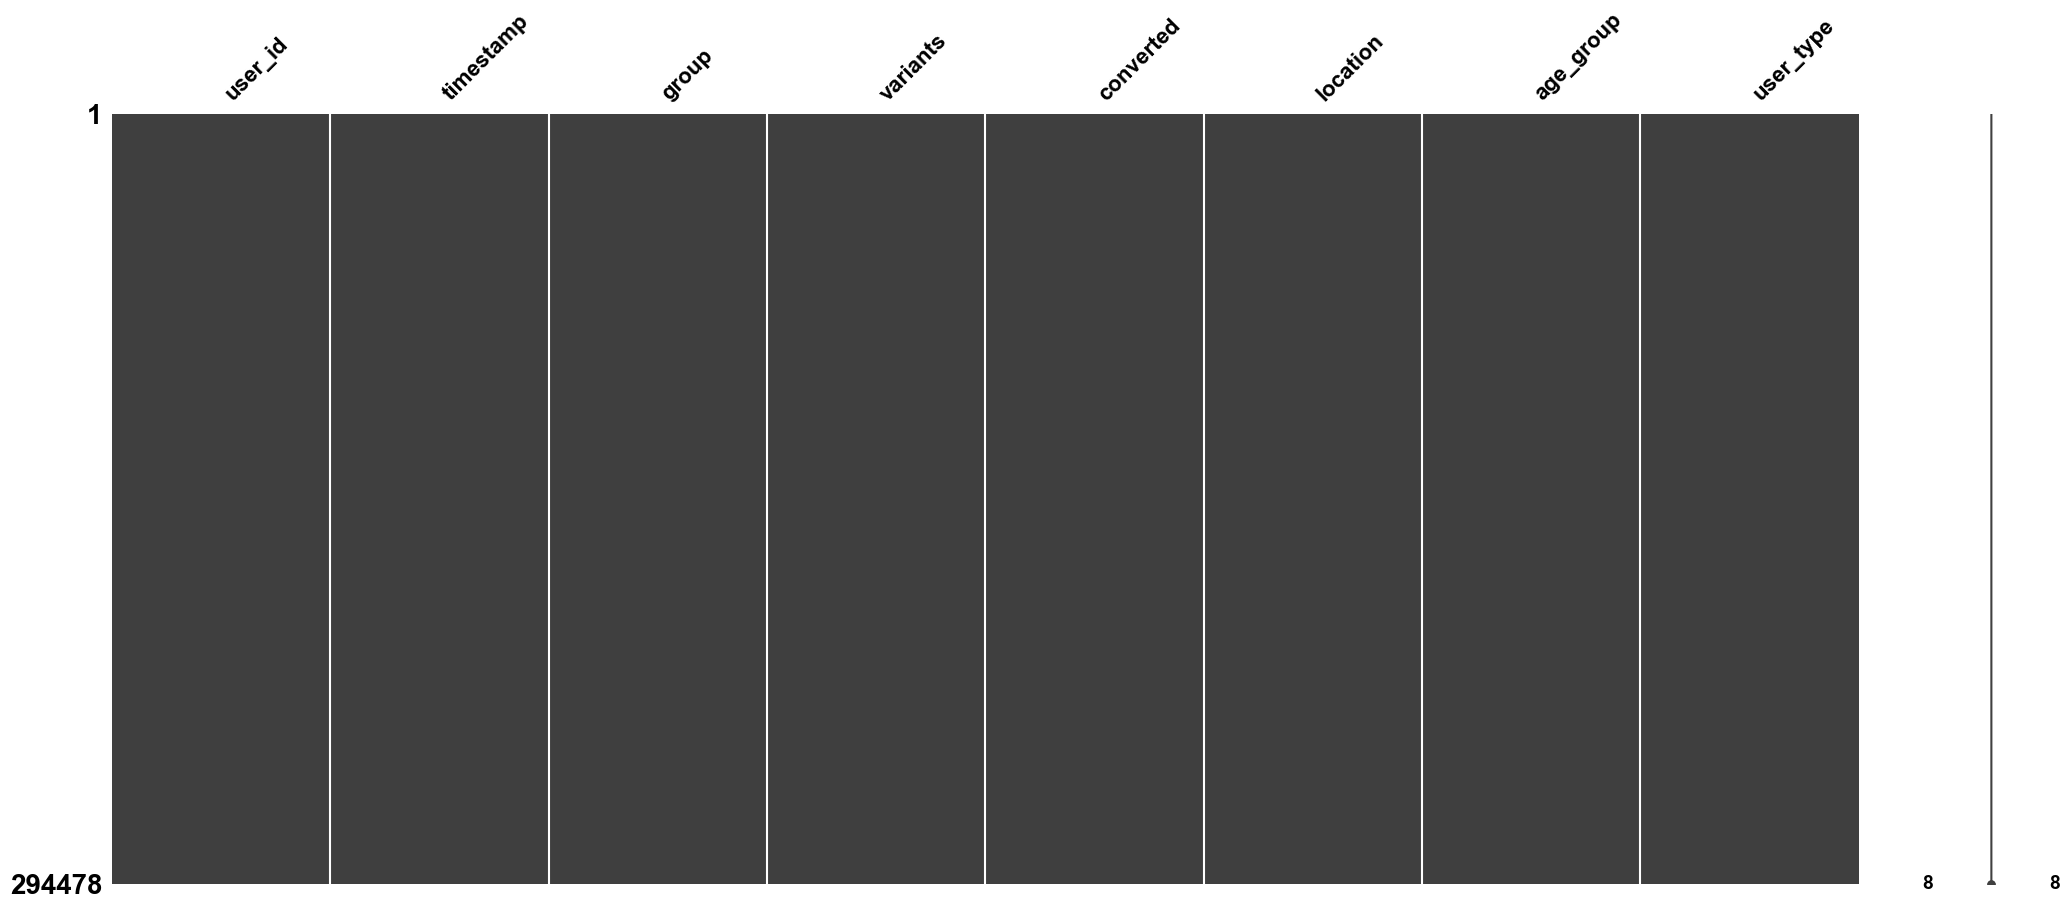

<Figure size 1500x900 with 0 Axes>

In [53]:
# проверка на наличие нулевых значений не выявляет нулевые значения ни в одном из столбцов
import missingno as msno
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

In [54]:
df.age_group.value_counts(normalize=True)

age_group
26-33    0.167313
50-57    0.167177
58+      0.167014
42-49    0.166800
34-41    0.166063
18-25    0.165632
Name: proportion, dtype: float64

In [55]:
df.groupby('age_group')['converted'].value_counts(normalize=True)

age_group  converted
18-25      0            0.881743
           1            0.118257
26-33      0            0.879034
           1            0.120966
34-41      0            0.882684
           1            0.117316
42-49      0            0.880413
           1            0.119587
50-57      0            0.879240
           1            0.120760
58+        0            0.878960
           1            0.121040
Name: proportion, dtype: float64

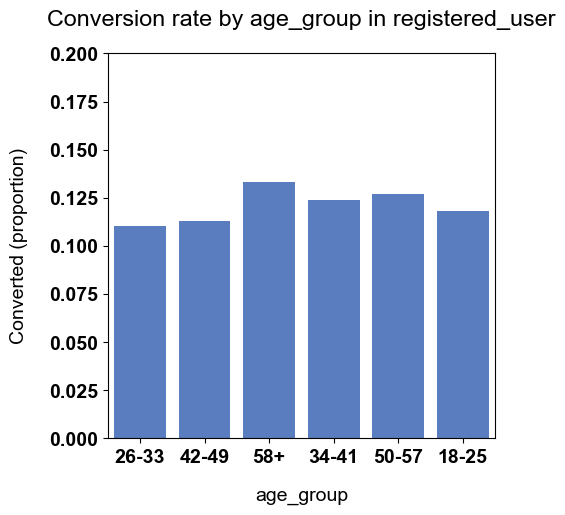

In [68]:
plt.figure(figsize=(5,5));
sns.barplot(x=ab_df_old_user['age_group'], y=ab_df_old_user['converted'], errorbar=('ci', False));
plt.ylim(0, 0.2);
plt.title('Conversion rate by age_group in registered_user', pad=20)
plt.xlabel('age_group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

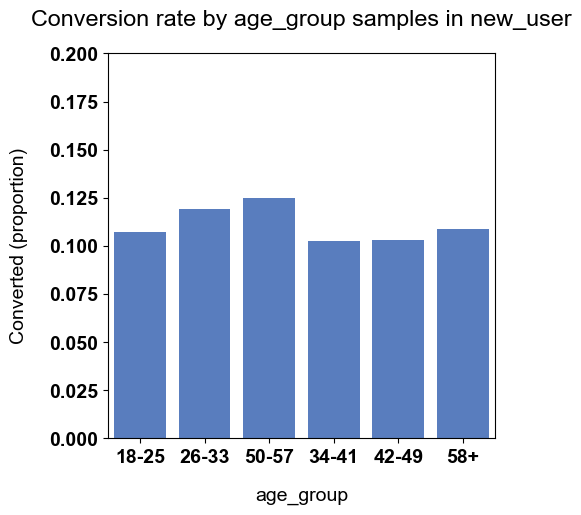

In [71]:
plt.figure(figsize=(5,5));
sns.barplot(x=ab_df_new_user['age_group'], y=ab_df_new_user['converted'], errorbar=('ci', False));
plt.ylim(0, 0.2);
plt.title('Conversion rate by age_group samples in new_user', pad=20)
plt.xlabel('age_group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [72]:
# в группе 'старых' пользователей самая высокая конверсия в самой возрастной подгруппе 58+
# в группе 'новых' пользователей самая высокая конверсия в подгруппе 50-57 